# Features and Correctness

We want to be able to describe our populations of sequences and compare them. To do this we extract various distributions, but we call them features. These features are designed such that they can be used to describe and measure correctness as a distance.

We define features as belonging to one of the following "domains":

- **Structural** features are designed to check for "structural zeros", ie outputs that should not be possible.
  - eg, if each sequence starts with a "home" activity
  - eg, if each sequence has a total duration of 24 hours
- **Participation** features check for the occurance of activity types in a sequence, they can be presented as **rates** or **probabilities**.
  - eg, if each sequence participates in the "work" activity or not
- **Transition** features describe the ordering of activities within sequences. 
  - eg, how many times a sequence transitions from "home" to "work"
- **times**/**scheduling** features describe when activities take place.
  - eg, the start time of all "shop" activities

We also use **frequency** features to describe the aggregate probability of an activity taking place in a given time bin. For example, "X% of agents are at work between 10am and 11am".

We also use **uniqueness** as a measure of diversity within a population of sequences.



In [3]:
import random

import pandas as pd

from caveat.describe import features
from caveat.describe.times import (
    joint_time_distributions_plot,
    times_distributions_plot,
)
from caveat.describe.transitions import sequence_prob_plot
from caveat.distance import mape, emd
from caveat.features import participation, times

In [4]:
# create some fake data
raw = pd.read_csv("data/synthetic_population.csv")


def down_sample(df, p):
    n_samples = int(len(df.pid.unique()) * p)
    sample_ids = random.sample(list(df.pid.unique()), n_samples)
    sampled = df[df.pid.isin(sample_ids)]
    return sampled


observed = down_sample(raw, 0.2)

a = down_sample(observed, 0.2)
b = down_sample(raw, 0.2)
synthetic = {"a": a, "b": b}



For example we can extract the start times for each activity and report the averages:

In [5]:
starts = times.start_times_by_act(observed)
features.average(starts)

education    845.806452
home         546.814988
leisure      812.727273
shop         624.824561
work         422.089552
dtype: float64

Note that the starts feature is a dictionary of tuples. Where the first value describes the 'support' of the feature and the second the frequncy of each observation.

We can take a better look at the distributions by plotting them:

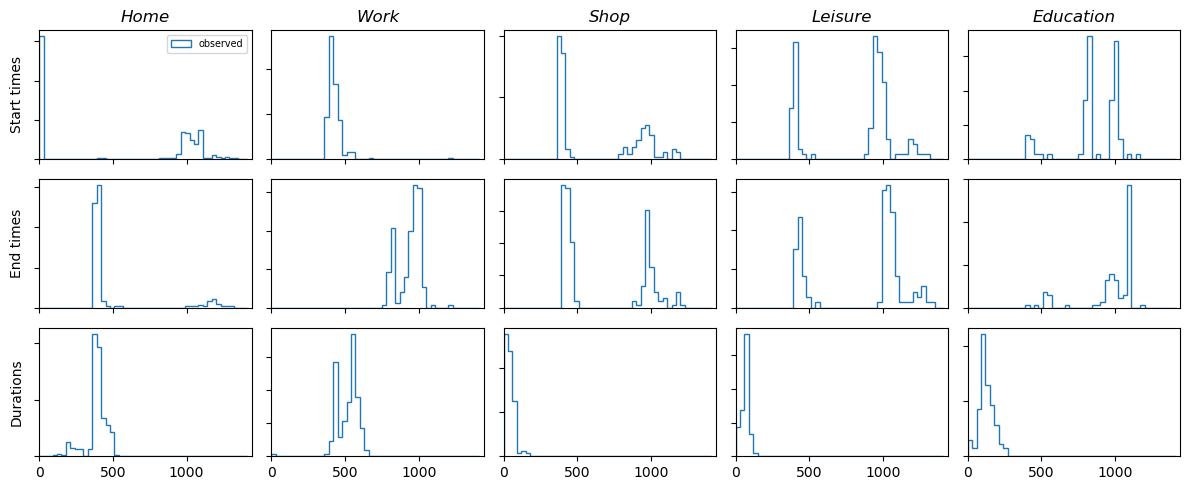

In [6]:
fig = times_distributions_plot(observed, None)

# Feature Structure

Features are commonly segmented into a dictionary of keys and values, where the key describes the segment. Features are commonly segmented by activity or transition type:

```
participation_probability = {
    "home": [1,1,1],
    "work": [1,0,0],
    "shop": [0,1,0]
}
```

In the above example, each feature segment records if each of the 3 segements contained a "home", "work" or "shop" activity.

In practice we compress this representation into frequency counts, represented by a tuple of the (i) possible values and (ii) their frequncies, in this simple case we get:

```
participation_probability = {
    "home": ([0, 1], [0, 3]),
    "work": ([0, 1], [2, 1]),
    "shop": ([0, 1], [2, 1]),
}
```

# Feature Descriptions

Features can be described or plotted using functions in the describe module:

In [7]:
participation_rates = participation.participation_rates_by_act(observed)
print(features.average(participation_rates))

education    0.465
home         2.135
leisure      0.605
shop         0.855
work         1.005
dtype: float64


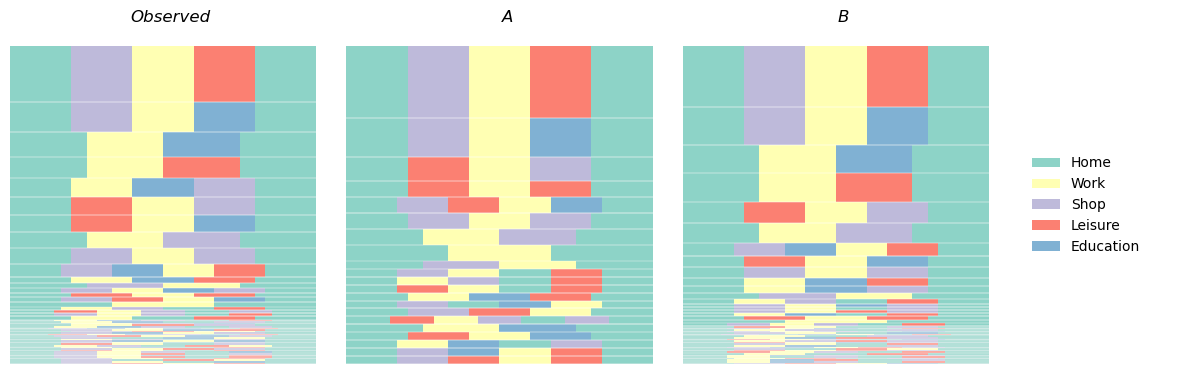

In [8]:
fig = sequence_prob_plot(observed, synthetic, figsize=(12, 4))

# Feature Segmentation

We can use more interesting types of segmentation to extact more descriptive features. For example we can enumerate activity type by it's location in the sequence:

In [9]:
participation_rates = participation.participation_rates_by_seq_act(observed)
print(features.average(participation_rates).head(10))

0home         1.000
1leisure      0.150
1shop         0.500
1work         0.350
2education    0.235
2home         0.035
2leisure      0.100
2shop         0.075
2work         0.555
3education    0.190
dtype: float64


Or by the enumeration of that type of activity in each sequence:

In [10]:
participation_rates = participation.participation_rates_by_act_enum(observed)
print(features.average(participation_rates).head(10))

education0    0.455
education1    0.010
home0         1.000
home1         1.000
home2         0.135
leisure0      0.570
leisure1      0.035
shop0         0.730
shop1         0.125
work0         1.000
dtype: float64


In these examples we use additional segmentation to get more information about the sequence. For example we can differentiate between the participation in (i) education as the third activity (2education) versus the fourth activity (3education), or (ii) the first education activity (education0) versus the second education activity (education1).

In all cases we use weighted averaging to combine segmented features into single metrics. Where weighting is ussually the number of each feature in the observed population of sequences.

# Dimensions

Start times are a one dimensional feature, but we can also consider multi-demnsional features:

In [11]:
start_durations = times.start_and_duration_by_act_bins(observed, bin_size=10)
# average 2d averages each dimension and then sums so that we can return an float
features.average2d(start_durations)

education    967.849462
home         932.693208
leisure      874.545455
shop         665.029240
work         935.970149
dtype: float64

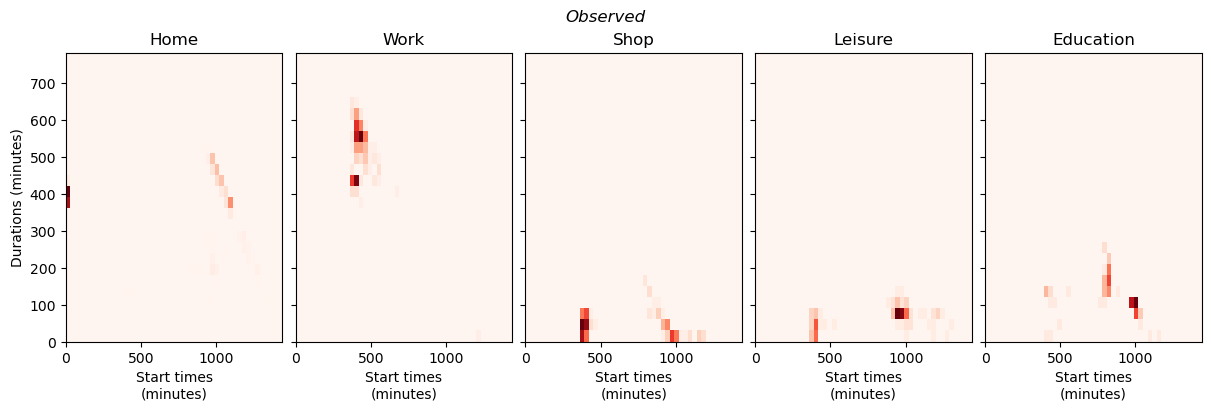

In [12]:
fig = joint_time_distributions_plot(observed, None, figsize=(12, 4))

# Distances

When comparing features we can generally see complex distributions:

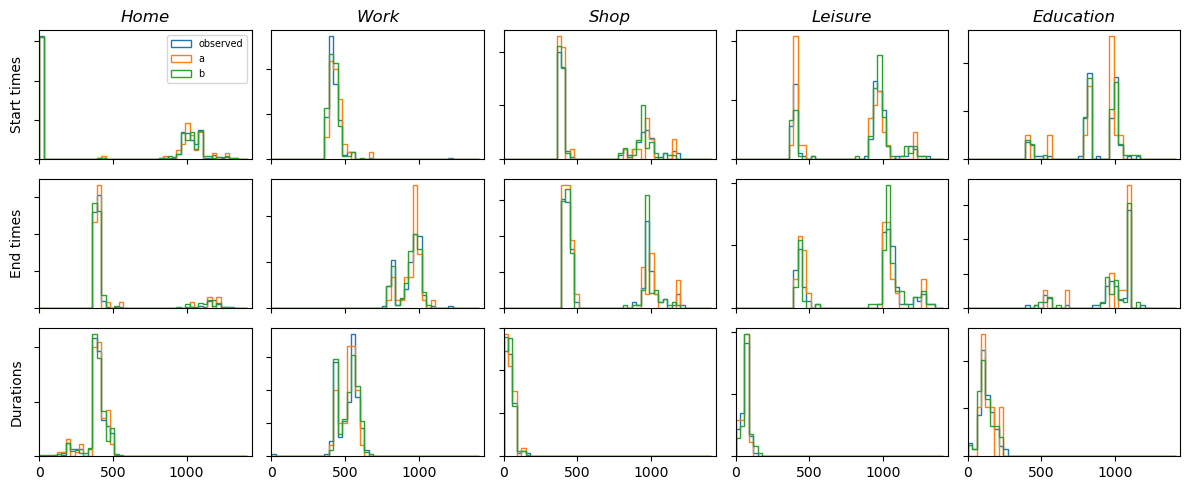

In [13]:
fig = times_distributions_plot(observed, synthetic)

To make a quantitave comparison between populations of sequences we primarilly use Wassersetin "earth movers" distance. This measure the amount of "work" required to make one distribuion match another.

In [14]:
x = times.start_times_by_act(observed)
ya = times.start_times_by_act(synthetic["a"])
yb = times.start_times_by_act(synthetic["b"])
print("synthetic population A: ", emd(x["home"], ya["home"]))
print("synthetic population B: ", emd(x["home"], yb["home"]))

synthetic population A:  8.073906649964593
synthetic population B:  5.224775224775256


In this case we might proclaim population B to be better. In practice we will use a lot more features and there will generally be trade-offs between them.

For probability features (in particular participation) we also sometime use absolute percentage error. This is particularly useful for highlighting the participation in uncommon activities which are often problematic for generative models.

In [15]:
x = participation.participation_prob_by_act(observed)
ya = participation.participation_prob_by_act(synthetic["a"])
yb = participation.participation_prob_by_act(synthetic["b"])
print("synthetic population A: ", mape(x["leisure"], ya["shop"]))
print("synthetic population B: ", mape(x["leisure"], yb["shop"]))

synthetic population A:  0.2875000000000001
synthetic population B:  0.2137931034482759


By this metric, population A appears better.